In [2]:
import pandas as pd
import numpy as np
import skimage as ski
from skimage import io as skio
import matplotlib.pyplot as plt
import cv2 as cv
from numba import jit 
from matplotlib.dates import DAYS_PER_YEAR
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from skimage.filters import threshold_otsu

def show(im, title="", size=7):
    plt.figure( figsize=(size,size))
    plt.imshow(im, cmap='gray')
    plt.title(title)
    plt.show()

In [3]:
@jit(nopython=True)
def normalize(im):
    return (im - im.min()) / (im.max() - im.min())

@jit(nopython=True)
def pixel_entropy(im, prob):
    entropy = np.zeros(im.shape, dtype=float)
    for i in range(entropy.shape[0]):
        for j in range(entropy.shape[1]):
            if prob[im[i,j]] == 0:
                entropy[i,j] = 0
            else:
                entropy[i,j] = - prob[im[i,j]] * np.log2(prob[im[i,j]])
    entropy = normalize(entropy)
    return entropy

#@jit(nopython=True)
def superpixel_entropy(entropy, segments):
#    entropy_values = (segments.max()+1) * [[]]
#    for i in range(segments.shape[0]):
#        for j in range(segments.shape[1]):
#            entropy_values[segments[i,j]].append(entropy[i,j])
    #print("entropy values", entropy_values[0], entropy_values[1])

    superpixel_entropy = np.zeros(segments.max()+1, dtype=float)
    for i in range(segments.max()+1):
        mask = segments == i
        masked_entropy = mask * entropy
        superpixel_entropy[i] = np.sum(masked_entropy)
        #superpixel_entropy[i] = sum(entropy_values[i]) #/ len(entropy_values[i])
        
    #print("superpixel entropy", superpixel_entropy)

    superpixel_entropy_image = np.zeros(segments.shape, dtype=float)
    for i in range(segments.shape[0]):
        for j in range(segments.shape[1]):
            superpixel_entropy_image[i,j] = superpixel_entropy[segments[i,j]]

    superpixel_entropy_image = normalize(superpixel_entropy_image)
    return superpixel_entropy_image

def information_saliency(im, n_segments = 1000, sigma = 1, wl = 1./3, wa = 1./3, wb = 1./3):
    im_lab = ski.color.rgb2lab(im)
    segments = slic(im_lab, n_segments = n_segments, sigma = sigma, convert2lab=False)
    #show(mark_boundaries(im, segments))

    superpixel_entropy_image = [None] * im.shape[2]
    for c in range(im.shape[2]):  
        hist, bin_edges = np.histogram(im[:,:,c], bins=256)
        prob = hist / im.size
        pixel_entropy_image = pixel_entropy(im[:,:,c], prob)
        superpixel_entropy_image[c] = superpixel_entropy(pixel_entropy_image, segments)
        
        #show(pixel_entropy_image)
        #show(superpixel_entropy_image[c])

    entropy = superpixel_entropy_image[0]*wl + superpixel_entropy_image[1]*wa + superpixel_entropy_image[2]*wb
    entropy = np.array(entropy)
    return entropy

In [4]:
@jit(nopython=True)
def pixel_saliency(value, hist):
    counter = 0
    for pixel_value, frequency in enumerate(hist):
            counter += abs(value - pixel_value) * frequency
    return counter

@jit(nopython=True)
def single_channel_saliency(im, hist):
    saliency = np.zeros(im.shape)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            saliency[i,j] = pixel_saliency(im[i,j], hist)
    return saliency

#@jit(nopython=False)
def statistical_saliency(im, wl = 1./3, wa = 1./3, wb = 1./3, sigma = 1):
    im_lab = ski.color.rgb2lab(im)
    saliency = np.zeros(im.shape)
    for c in range(im.shape[2]):
        hist, bin_edges = np.histogram(im_lab[:,:,c], bins=256, range=(0,1))
        saliency[:,:,c] = single_channel_saliency(im_lab[:,:,c], hist)
    
    saliency_mean = saliency[:,:,0]*wl + saliency[:,:,1]*wa + saliency[:,:,2]*wb
    filtered_saliency = cv.GaussianBlur(saliency_mean, (3,3), sigma)
    return filtered_saliency

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

def recreate_image(codebook, labels, w, h):
    image = np.zeros((w, h))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image


def km (im, n_class):
    n_class = n_class

# Load Image and transform to a 2D numpy array.
    w, h = original_shape = tuple(im.shape)
    d = 1
    image_array = np.reshape(im, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=n_class, random_state=0).fit(image_array_sample)

    labels = kmeans.predict(image_array)
    
    return recreate_image(kmeans.cluster_centers_, labels, w, h)

/tmp/ipykernel_91065/1344636041.py:44: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(im_lab, n_segments = n_segments, sigma = sigma, convert2lab=False)
/tmp/ipykernel_91065/2033884592.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Text(0.5, 1.0, 'Min Otsu')

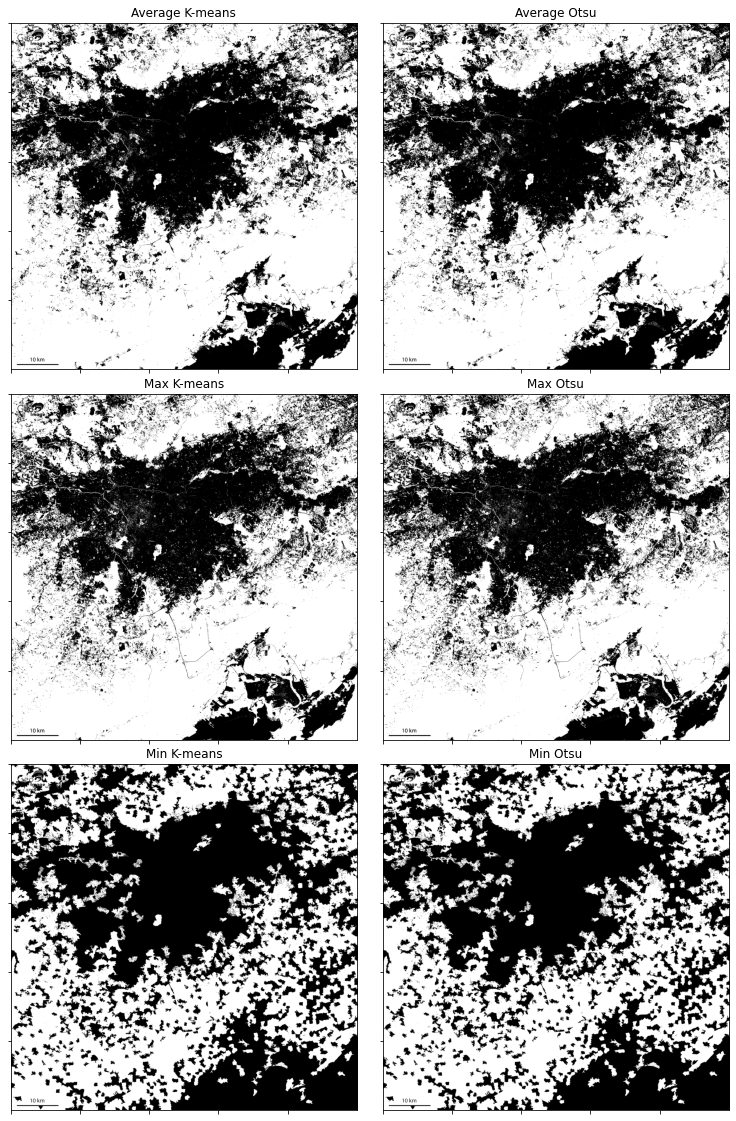

In [6]:
im = skio.imread('imgs/sp.jpg')

#Get saliency
saliency = normalize(statistical_saliency(im, wl = 1, wa=0, wb=0, sigma=0))

#Get entropy
entropy = information_saliency(im[:, :, :], n_segments=10000)

m = (saliency + entropy)/2
kav = normalize(km(m, 2))
tav = threshold_otsu(m)
binav = m > tav


maximum = np.maximum(entropy, saliency)
kmax = normalize(km(maximum, 2))
tmax = threshold_otsu(maximum)
binmax = maximum > tmax

minimum = np.minimum(entropy, saliency)
kmin = normalize(km(minimum, 2))
tmin = threshold_otsu(minimum)
binmin = minimum > tmin






fig, axs = plt.subplots(3, 2, figsize=(20,20), gridspec_kw = {'wspace':-.5, 'hspace':.07})

for i, ax in enumerate(fig.axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.tight_layout()



axs[0, 0].imshow(kav, cmap='gray')
axs[0, 0].set_title('Average K-means')
axs[0, 1].imshow(binav, cmap='gray')
axs[0, 1].set_title('Average Otsu')
axs[1, 0].imshow(kmax, cmap='gray')
axs[1, 0].set_title('Max K-means')
axs[1, 1].imshow(binmax, cmap='gray')
axs[1, 1].set_title('Max Otsu')
axs[2, 0].imshow(kmin, cmap='gray')
axs[2, 0].set_title('Min K-means')
axs[2, 1].imshow(binmin, cmap='gray')
axs[2, 1].set_title('Min Otsu')



/tmp/ipykernel_91065/3416723927.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Text(0.5, 1.0, 'Statistical Information Otsu')

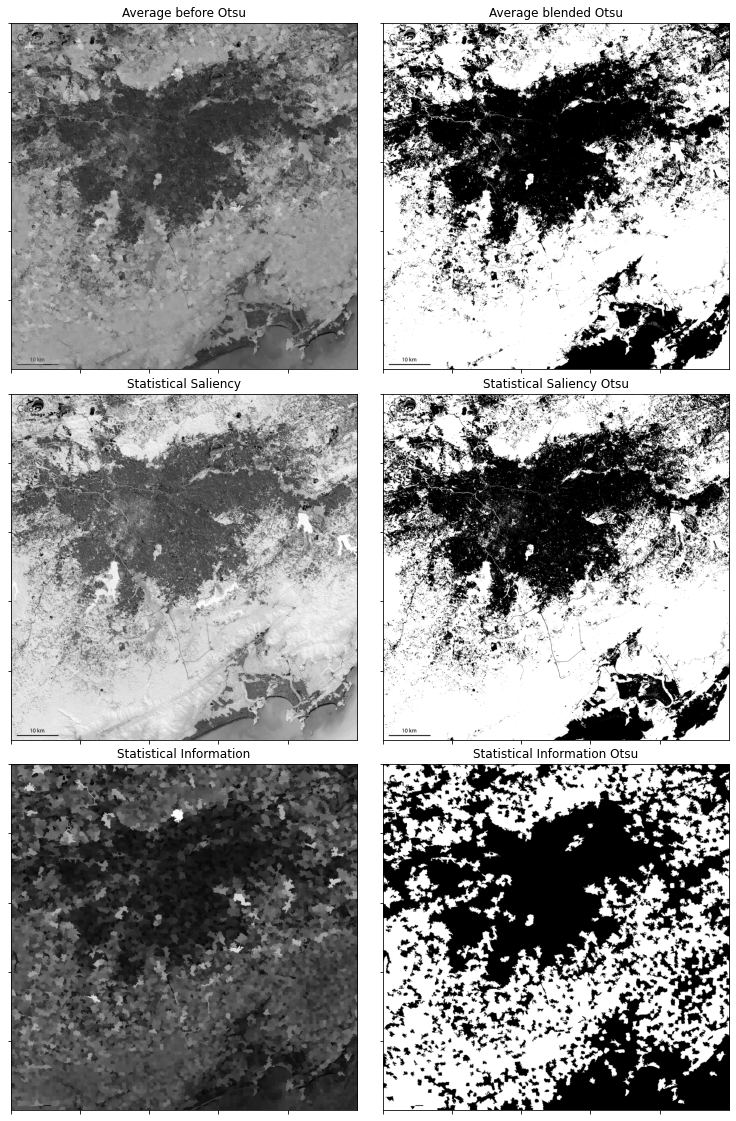

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(20,20), gridspec_kw = {'wspace':-.5, 'hspace':.07})

for i, ax in enumerate(fig.axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.tight_layout()

tn = threshold_otsu(saliency)
binn = saliency > tn

te = threshold_otsu(entropy)
bine = entropy > te


axs[0,0].imshow(m, cmap='gray')
axs[0,0].set_title('Average before Otsu')
axs[0,1].imshow(binav, cmap='gray')
axs[0,1].set_title('Average blended Otsu')
axs[1,0].imshow(saliency, cmap='gray')
axs[1,0].set_title('Statistical Saliency')
axs[1,1].imshow(binn, cmap='gray')
axs[1,1].set_title('Statistical Saliency Otsu')
axs[2,0].imshow(entropy, cmap='gray')
axs[2,0].set_title('Statistical Information')
axs[2,1].imshow(bine, cmap='gray')
axs[2,1].set_title('Statistical Information Otsu')


/tmp/ipykernel_74527/3172052133.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Text(0.5, 1.0, 'Min Otsu')

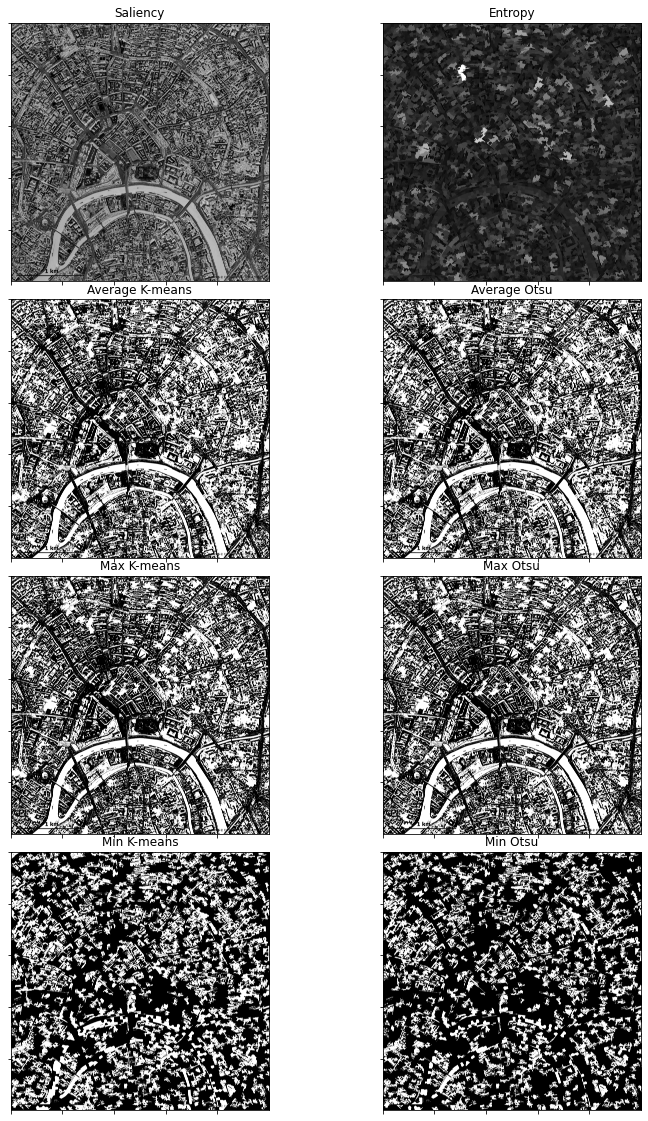

In [9]:





fig, axs = plt.subplots(3, 2, figsize=(20,20), gridspec_kw = {'wspace':-.5, 'hspace':.07})

for i, ax in enumerate(fig.axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.tight_layout()



axs[0, 0].imshow(kav, cmap='gray')
axs[0, 0].set_title('Average K-means')
axs[0, 1].imshow(binav, cmap='gray')
axs[0, 1].set_title('Average Otsu')
axs[1, 0].imshow(kmax, cmap='gray')
axs[1, 0].set_title('Max K-means')
axs[1, 1].imshow(binmax, cmap='gray')
axs[1, 1].set_title('Max Otsu')
axs[2, 0].imshow(kmin, cmap='gray')
axs[2, 0].set_title('Min K-means')
axs[2, 1].imshow(binmin, cmap='gray')
axs[2, 1].set_title('Min Otsu')

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,15), gridspec_kw = {'wspace':-.5, 'hspace':.07})

for i, ax in enumerate(fig.axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.tight_layout()

axs[0].imshow(entropy, cmap='gray')
axs[1].imshow(saliency, cmap='gray')
axs[2].imshow(m, cmap='gray')

/tmp/ipykernel_74527/400722979.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


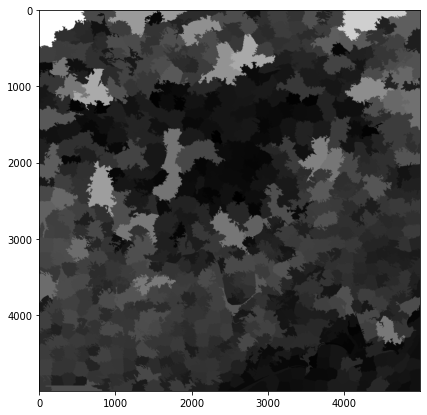

In [10]:
show(entropy)

In [14]:
b = entropy


In [15]:
np.maximum(b, entropy)

array([[1.        , 1.        , 1.        , ..., 0.36729462, 0.36729462,
        0.36729462],
       [1.        , 1.        , 1.        , ..., 0.36729462, 0.36729462,
        0.36729462],
       [1.        , 1.        , 1.        , ..., 0.36729462, 0.36729462,
        0.36729462],
       ...,
       [0.21336423, 0.21336423, 0.21336423, ..., 0.06471955, 0.06471955,
        0.06471955],
       [0.21336423, 0.21336423, 0.21336423, ..., 0.06471955, 0.06471955,
        0.06471955],
       [0.21336423, 0.21336423, 0.21336423, ..., 0.06471955, 0.06471955,
        0.06471955]])

In [ ]:
im = skio.imread('imgs/sp.jpg')
im_lab = ski.color.rgb2lab(im)
segments = slic(im_lab, n_segments = 1000, sigma = 1, convert2lab=False)
print(segments)

/tmp/ipykernel_119062/2671881713.py:3: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(im_lab, n_segments = 1000, sigma = 1, convert2lab=False)


[[  0   0   0 ...  14  14  14]
 [  0   0   0 ...  14  14  14]
 [  0   0   0 ...  14  14  14]
 ...
 [632 632 632 ... 640 640 640]
 [632 632 632 ... 640 640 640]
 [632 632 632 ... 640 640 640]]


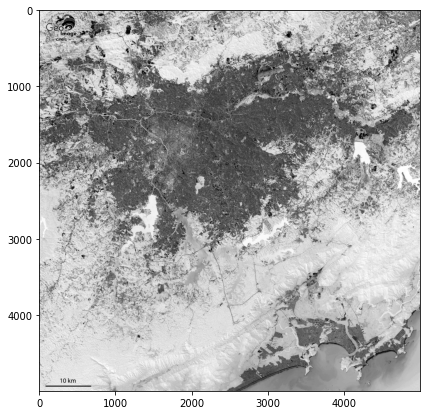

In [17]:
im = skio.imread('imgs/sp.jpg')
saliency = normalize(statistical_saliency(im, wl = 1, wa=0, wb=0, sigma=0))
show(saliency)

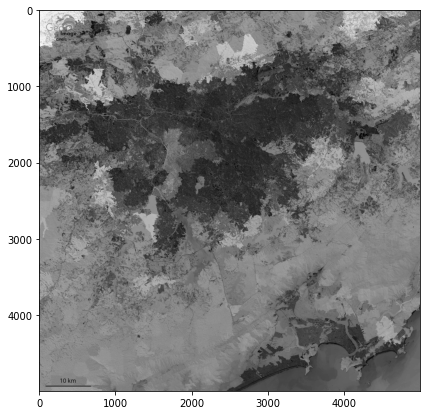

In [34]:
m = (saliency + entropy)/2
show (m)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

def recreate_image(codebook, labels, w, h):
    image = np.zeros((w, h))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image


def km (im, n_class):
    n_class = n_class

# Load Image and transform to a 2D numpy array.
    w, h = original_shape = tuple(im.shape)
    d = 1
    image_array = np.reshape(im, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=n_class, random_state=0).fit(image_array_sample)

    labels = kmeans.predict(image_array)
    
    return recreate_image(kmeans.cluster_centers_, labels, w, h)

In [44]:
k = normalize(km(saliency, 2))
t = threshold_otsu(saliency)
bin = saliency > t

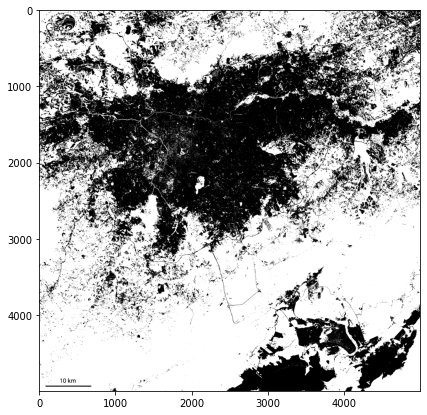

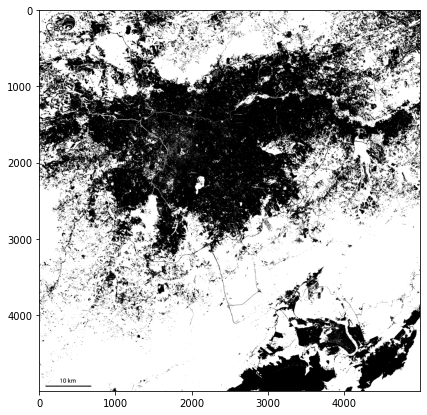

In [45]:
show(k)
show(bin)

In [37]:
ke = normalize(km(entropy, 2))
te = threshold_otsu(entropy)
bine = entropy > te

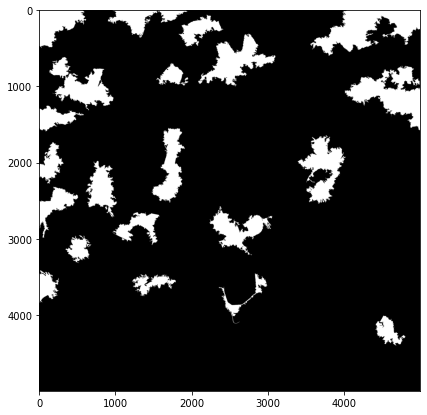

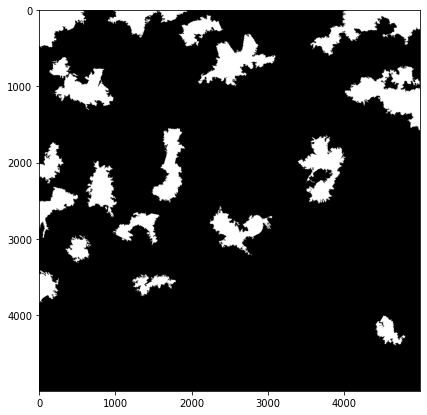

In [38]:
show(ke)
show(bine)

In [39]:
km = normalize(km(m, 2))
tm = threshold_otsu(m)
binm = m > tm

TypeError: Image data of dtype object cannot be converted to float

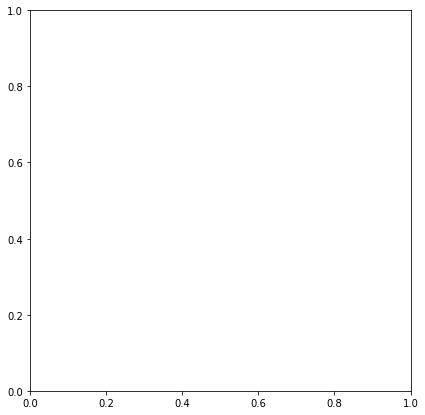

In [51]:
show(km)
show(binm)

In [48]:
bin - binm

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [32]:
k.tolist() == bin.tolist()

False

In [39]:
(k != bin).mean()

0.0012692

In [ ]:
(k != bin,).sum()

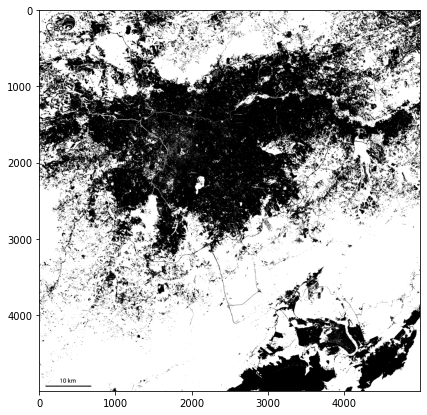

In [46]:
t = threshold_otsu(saliency)
bin = saliency > t
show(bin)

In [69]:
True in ((saliency>t)[2] == (saliency>t)[1])

True

In [31]:
im_lab = ski.color.rgb2lab(im[0:1000, 0:1000, :]/255)

In [32]:
saliency = np.zeros(im_lab.shape)
for c in range(im_lab.shape[2]):
    hist, bin_edges = np.histogram(im_lab[:,:,c], bins=256, range=(0,1))
    for i in range(im_lab.shape[0]):
        for j in range(im_lab.shape[1]):
            saliency[i,j,c] = pixel_saliency(im_lab[i,j,c], hist)

plt.imshow(saliency[:,:,0])

KeyboardInterrupt: 

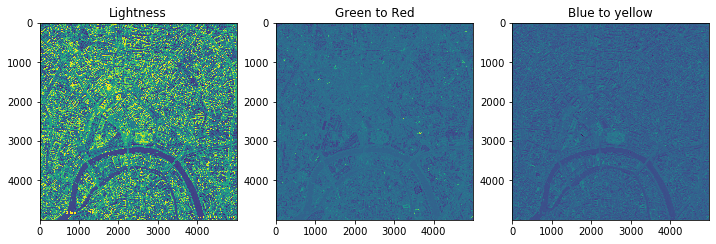

In [20]:
fig, ax = plt.subplots(1,3, figsize=(12,12))
ax[0].imshow(im_lab[:,:,0]) 
ax[0].set_title('Lightness')
ax[1].imshow(im_lab[:,:,1])
ax[1].set_title('Green to Red')
ax[2].imshow(im_lab[:,:,2])
ax[2].set_title('Blue to yellow')
plt.show()

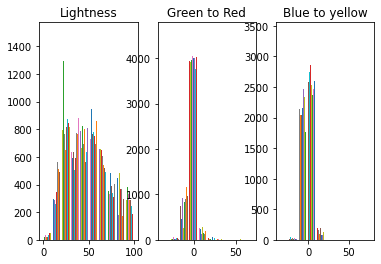

In [24]:
fig, ax = plt.subplots(1,3)
ax[0].hist(im_lab[:,:,0]) 
ax[0].set_title('Lightness')
ax[1].hist(im_lab[:,:,1])
ax[1].set_title('Green to Red')
ax[2].hist(im_lab[:,:,2])
ax[2].set_title('Blue to yellow')
plt.show()

In [6]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

@jit(nopython=True)
def information_saliency_loop(segments, prob):
    saliency = np.zeros(segments.shape)
    for i in range(saliency.shape[0]):
        for j in range(saliency.shape[1]):
            saliency[i,j] = - prob[segments[i,j]] * np.log2(prob[segments[i,j]])
    return saliency

def information_saliency(im, n_segments = 1000, sigma = 1):
    im_lab = ski.color.rgb2lab(im)
    segments = slic(im_lab, n_segments = n_segments, sigma = sigma, convert2lab=False)
    show(mark_boundaries(im, segments))
    for c in range(im.shape[2]):  
        hist, bin_edges = np.histogram(im_lab[:,:,c], bins=segments.max()+1)
        prob = hist / im.size
    saliency = information_saliency_loop(segments, prob)
    
    return saliency

In [38]:
im = skio.imread('imgs/sp.jpg')
im_lab = ski.color.rgb2lab(im)
segments = slic(im_lab, n_segments = 1000, sigma = 1, convert2lab=False)
print(segments)

<ipython-input-38-847c2720ed24>:2: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(im_lab, n_segments = 1000, sigma = 1, convert2lab=False)


[[  0   0   0 ...  10  10  10]
 [  0   0   0 ...  10  10  10]
 [  0   0   0 ...  10  10  10]
 ...
 [224 224 224 ... 267 267 267]
 [224 224 224 ... 267 267 267]
 [224 224 224 ... 267 267 267]]


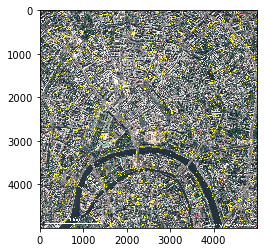

In [39]:
plt.imshow(mark_boundaries(im, segments))

<ipython-input-6-0cddbde201cc>:17: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(im_lab, n_segments = n_segments, sigma = sigma, convert2lab=False)


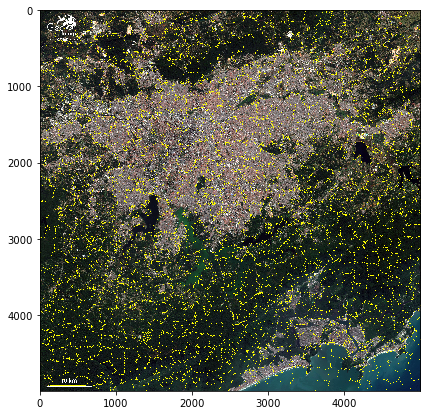

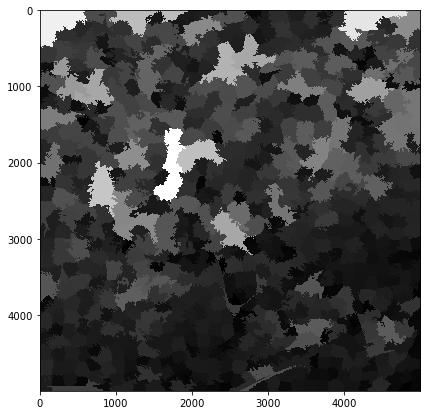

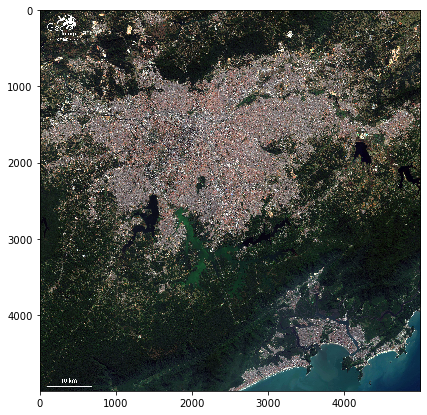

In [7]:
im = skio.imread('imgs/sp.jpg')/255
saliency = information_saliency(im)
show(saliency)
show(im)

In [23]:
hist, bin_edges = np.histogram(segments, bins = segments.max()+1)
print(hist)

263


1309

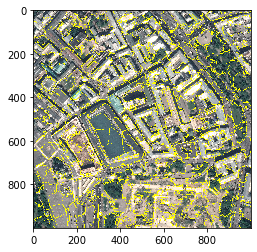

In [7]:
plt.imshow(mark_boundaries(im[2000:3000, 2000:3000, :], segments))

In [80]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

for numSegments in (1, 500):
	# apply SLIC and extract (approximately) the supplied number
	# of segments
	segments = slic(im, n_segments = numSegments, sigma = 1, convert2lab=True)
	# show the output of SLIC
	fig = plt.figure("Superpixels -- %d segments" % (numSegments))
	ax = fig.add_subplot(1, 1, 1)
	ax.imshow(mark_boundaries(im, segments))
	plt.axis("off")
# show the plots
plt.show()

: 

: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


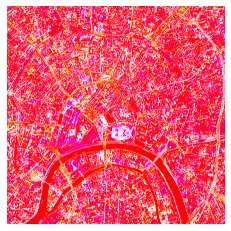

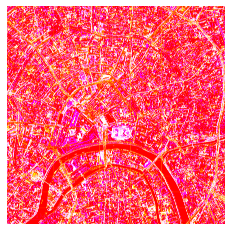

In [5]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

for numSegments in (1, 200):
	# apply SLIC and extract (approximately) the supplied number
	# of segments
	segments = slic(im, n_segments = numSegments, sigma = 1, convert2lab=True)
	# show the output of SLIC
	fig = plt.figure("Superpixels -- %d segments" % (numSegments))
	ax = fig.add_subplot(1, 1, 1)
	ax.imshow(mark_boundaries(im, segments))
	plt.axis("off")
# show the plots
plt.show()

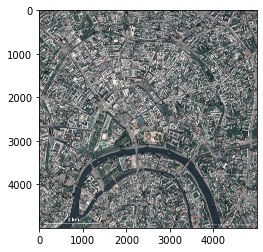

In [7]:
plt.imshow(mark_boundaries(im, segments, color=0, outline_color=0, mode='inner'))

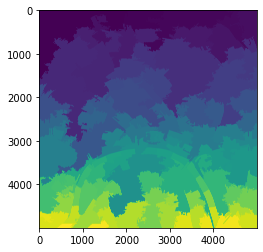

In [5]:
plt.imshow(segments)

In [3]:
counter = 0
from tqdm import tqdm
for i in tqdm(range(4000)):
    for j in range(4000):
        for k in range(4000):
            for m in range(4000):
                counter += 1

counter

  0%|          | 0/4000 [00:54<?, ?it/s]


KeyboardInterrupt: 